<a href="https://colab.research.google.com/github/mt508/machine-learning-/blob/main/studentperformance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
from zlib import crc32
import numpy as np


In [13]:


data_student = pd.read_csv('/content/sample_data/Student_Performance.csv')


In [14]:
data_student.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [15]:
data_student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


observations are


1.   no missing value
2.   string object is 1 extracurricular Activities



array([[<Axes: title={'center': 'Hours Studied'}>,
        <Axes: title={'center': 'Previous Scores'}>],
       [<Axes: title={'center': 'Sleep Hours'}>,
        <Axes: title={'center': 'Sample Question Papers Practiced'}>],
       [<Axes: title={'center': 'Performance Index'}>, <Axes: >]],
      dtype=object)

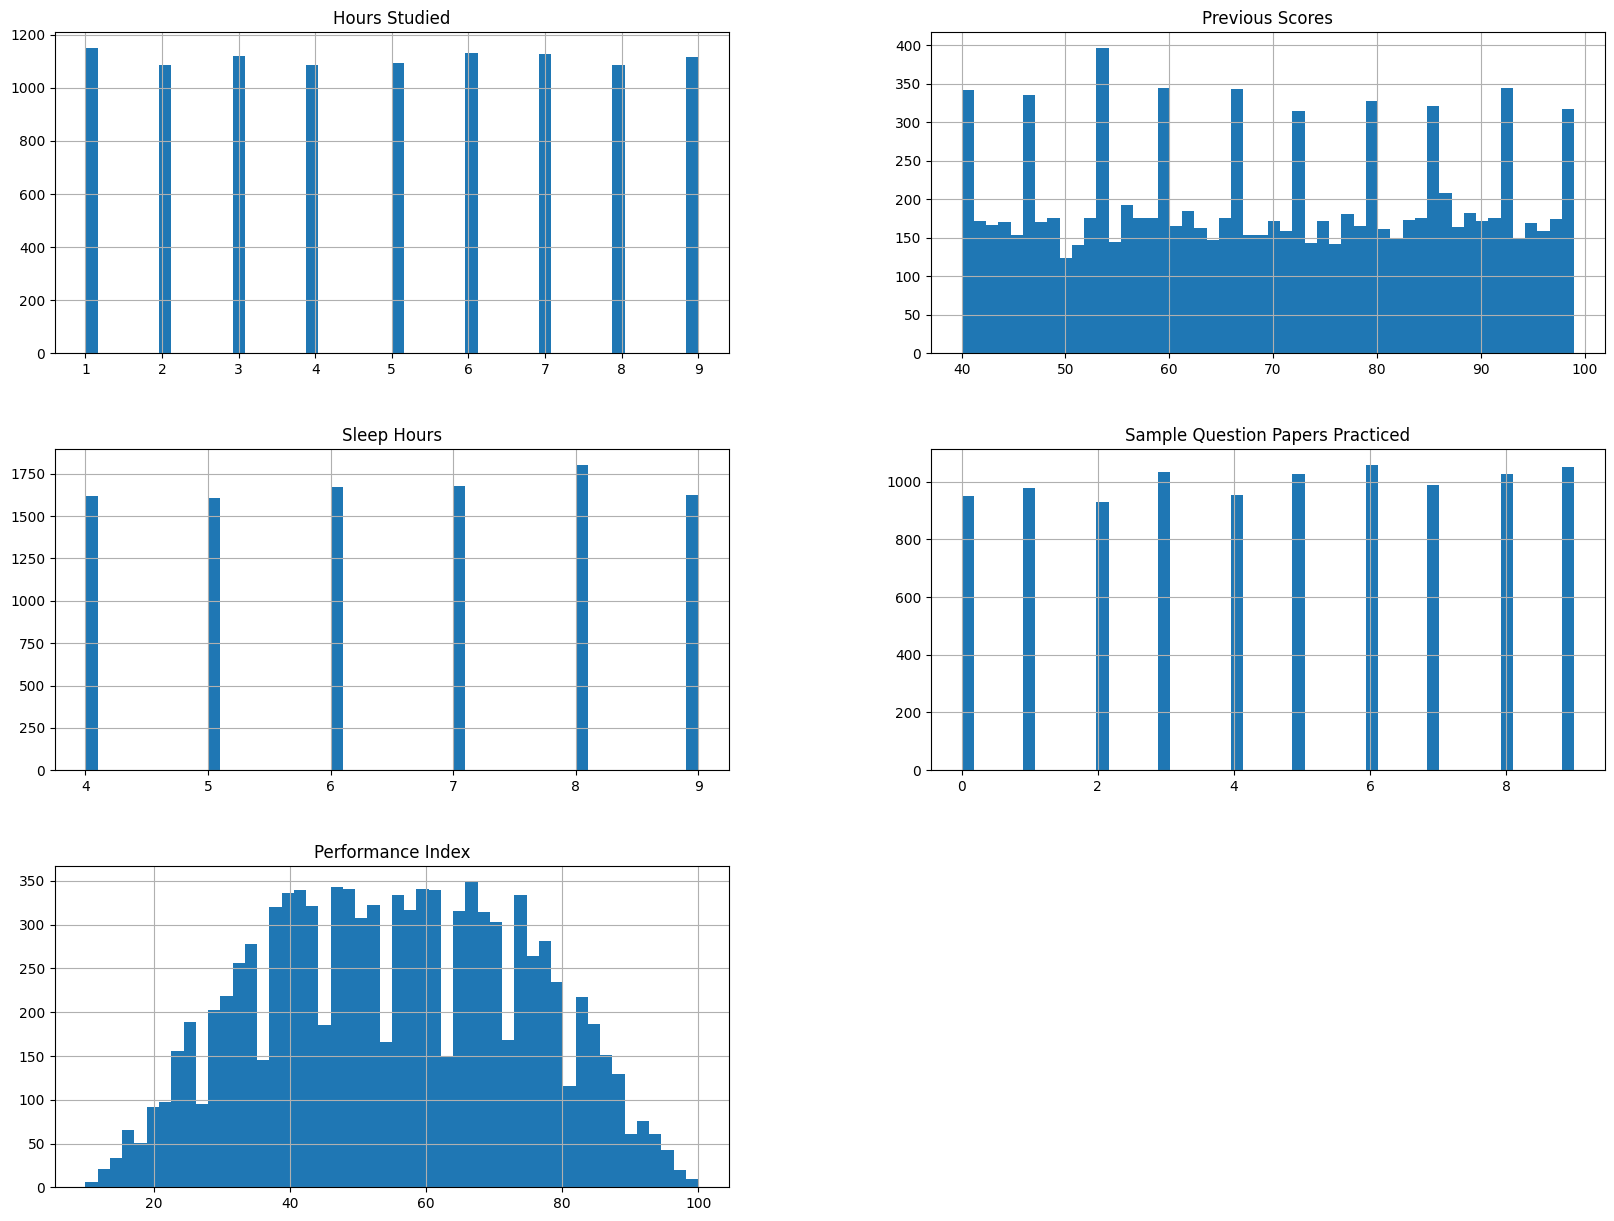

In [16]:
data_student.hist(bins=50, figsize=(20,15))

In [17]:
def is_id_in_test_set(identifier,testratio):
  return crc32(np.int64(identifier))<=testratio*2**32

In [24]:
def split_data(data, id_column,testratio):
  id=data[id_column]
  is_test_set=id.apply(lambda id_:is_id_in_test_set(id_,0.2))
  train_set=data.loc[~is_test_set]
  test_set=data.loc[is_test_set]
  return train_set,test_set

In [22]:
data_with_id=data_student.copy()
data_with_id["id"]=data_with_id.index

In [26]:
train_set,test_set=split_data(data_with_id,"id",0.2)

In [35]:
data_with_id['perf_cat']=pd.cut(data_with_id['Performance Index'],bins=[0, 50, 75, 90, 100],
    labels=[1, 2, 3, 4] )

<Axes: xlabel='perf_cat'>

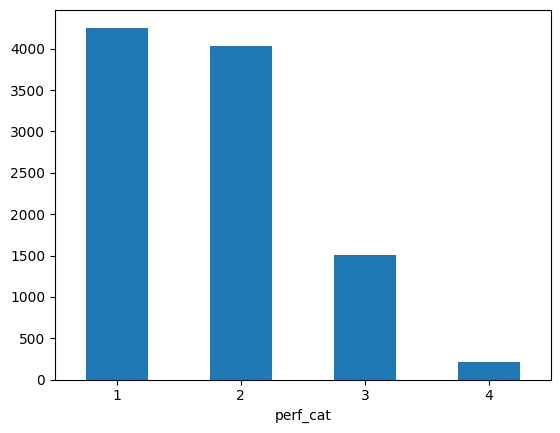

In [36]:
data_with_id['perf_cat'].value_counts().sort_index().plot.bar(rot=0)

In [40]:
from sklearn.model_selection import StratifiedShuffleSplit
start_split=[]
Stratifier= StratifiedShuffleSplit(n_splits=10,test_size=0.2,random_state=42)
for train_index,test_index in Stratifier.split(data_with_id,data_with_id['perf_cat']):
  strat_train_set = data_with_id.iloc[train_index].drop('perf_cat', axis=1)
  strat_test_set = data_with_id.iloc[test_index].drop('perf_cat', axis=1)
  start_split.append((strat_train_set,strat_test_set))


In [41]:
train_set_strat=start_split[0]
test_set_strat=start_split[0]